# Solver performance testing [local]

**Brendan Smithyman** | [bsmithym@uwo.ca](mailto:bsmithym@uwo.ca) | May, 2015

### Import NumPy

In [1]:
import numpy as np
import SimPEG
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
from pymatsolver.Solver import Solver
from pymatsolver import MumpsSolver

In [2]:
import line_profiler
import IPython
ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

### Import plotting tools from matplotlib and set format defaults

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 150 # Change this to adjust figure size

# Plotting options
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'normal',
    'size': 8,
}

matplotlib.rc('font', **font)

# import mpld3
# mpld3.enable_notebook()

## Base system configuration

In [4]:
# ------------------------------------------------
# Model geometry

cellSize    = 1             # m
freq        = 3e2           # Hz
nx          = 100           # count
nz          = 200           # count
dims        = (nz, nx)

# ------------------------------------------------
# Model properties


velocity    = 3000          # m/s
vanom       = 0             # m/s
density     = 2294          # units of density
Q           = np.inf        # can be inf

cPert       = np.zeros(dims)
cPert[(nz/2)-20:(nz/2)+20,(nx/2)-20:(nx/2)+20] = vanom
c           = np.fliplr(np.ones(dims) * velocity)
c          += np.fliplr(cPert)
rho         = np.fliplr(np.ones((nz,nx)) * density)

# ------------------------------------------------
# Survey geometry

srcs        = np.array([np.ones(171)*15, np.zeros(171), np.linspace(15, 185, 171)]).T
recs        = np.array([np.ones(171)*85, np.zeros(171), np.linspace(15, 185, 171)]).T
nsrc        = len(srcs)
nrec        = len(recs)
recmode     = 'fixed'

geom        = {
    'src':  srcs,
    'rec':  recs,
    'mode': recmode,
}

# ------------------------------------------------
# Other parameters

ky          = 0
freeSurf    = [False, False, False, False] # t r b l

nPML        = 30

# Base configuration for all subproblems
systemConfig = {
    'dx':       cellSize,   # m
    'dz':       cellSize,   # m
    'c':        c,          # m/s
    'rho':      rho,        # density
    'Q':        Q,          # can be inf
    'nx':       nx,         # count
    'nz':       nz,         # count
    'freeSurf': freeSurf,   # t r b l
    'nPML':     nPML,
    'geom':     geom,
    'freq':     freq,
    'ky':       0,
#     'Solver':   SimPEG.SolverWrapD(linalg.splu),#I(linalg.gmres),
    'Solver':   lambda A: MumpsSolver(A, symmetric=False),#lambda A: Solver(A, doDirect=True, flag=None, options={'factorize':True,'backend':'scipy'})
    'ireg':     4,
}

### Plotting functions

These are convenience functions to allow us to set plotting limits in one place. Since we're defining these with closures to save effort, they need to go after the system configuration to grab things like the geometry after it's defined.

In [5]:
sms = 4
rms = 0.5

def plotField(u):
    clip = 0.1*abs(u).max()
    plt.imshow(u.real, cmap=cm.bwr, vmin=-clip, vmax=clip)

def plotModel(v):
    lclip = 2000
    hclip = 3000
    plt.imshow(v.real, cmap=cm.jet, vmin=lclip, vmax=hclip)

def plotGeometry():
    
    srcpos = srcs[activeSource][::2]
    recpos = recs[:,::2]
    
    axistemp = plt.axis()
    plt.plot(srcpos[0], srcpos[1], 'kx', markersize=sms)
    plt.plot(recpos[:,0], recpos[:,1], 'kv', markersize=rms)
    plt.axis(axistemp)

## Performance testing

Setting up the system

In [6]:
from zephyr.Kernel import SeisFDFDKernel
sp = SeisFDFDKernel(systemConfig)

Getting the current velocity, setting a central anomaly, resetting the matrix factors

In [7]:
cnew = sp.c
cnew[:] = 3000
cnew[(nz/2)-10:(nz/2)+10,(nx/2)-10:(nx/2)+10] += 3200
sp.c = cnew

Modelling synthetic 'true' data (calls to `sp.forward()` and `sp.backprop()` in this code are modelling *all* sources)

In [8]:
%%time
uF, dObs = sp.forward()
print('uF\tnelem: %d, nsrc: %d'%uF.shape)
print('dObs\tnrec: %d, nsrc: %d'%dObs.shape)

uF	nelem: 20000, nsrc: 171
dObs	nrec: 171, nsrc: 171
CPU times: user 3.15 s, sys: 112 ms, total: 3.26 s
Wall time: 1.06 s


Resetting to a flat model

In [9]:
cnew = sp.c
cnew[:] = 3000
sp.c = cnew

Modelling new 'predicted' data

In [10]:
%%time
uF, dPred = sp.forward()
print('uF\tnelem: %d, nsrc: %d'%uF.shape)
print('dPred\tnrec: %d, nsrc: %d'%dPred.shape)

uF	nelem: 20000, nsrc: 171
dPred	nrec: 171, nsrc: 171
CPU times: user 2.75 s, sys: 123 ms, total: 2.87 s
Wall time: 838 ms


Backpropagating the data residual

In [11]:
dResid = dPred - dObs

In [12]:
%%time
uB = sp.backprop(dresid=dResid)
print('uB\tnelem: %d, nsrc: %d'%uB.shape)

uB	nelem: 20000, nsrc: 171
CPU times: user 2.53 s, sys: 111 ms, total: 2.64 s
Wall time: 772 ms


## Plots

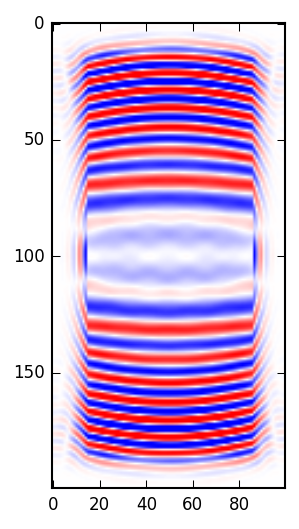

In [13]:
g = (uF*uB).sum(axis=1)
clip = 0.5 * abs(g).max()
plt.imshow((uF*uB).sum(axis=1).reshape((nz,nx)).real, cmap=cm.bwr, vmin=-clip, vmax=clip)

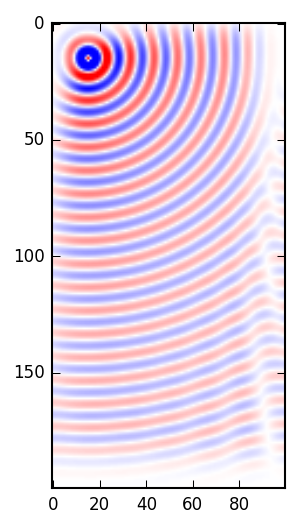

In [14]:
isrc = 0
clip = 0.1 * abs(uF[:,0]).max()
plt.imshow(uF[:,0].reshape((nz,nx)).real, cmap=cm.bwr, vmin=-clip, vmax=clip)